In [1]:
%pip install wandb
import wandb
from matplotlib import pyplot as plt
import tikzplotlib
import pandas as pd
wandb.login()

Note: you may need to restart the kernel to use updated packages.


wandb: Currently logged in as: mg98 (tribler). Use `wandb login --relogin` to force relogin


True

/var/folders/fz/h_r0ypg14n9ck7sr91hf8ntm0000gn/T/ipykernel_30611/1681132196.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation=45, ha="right")


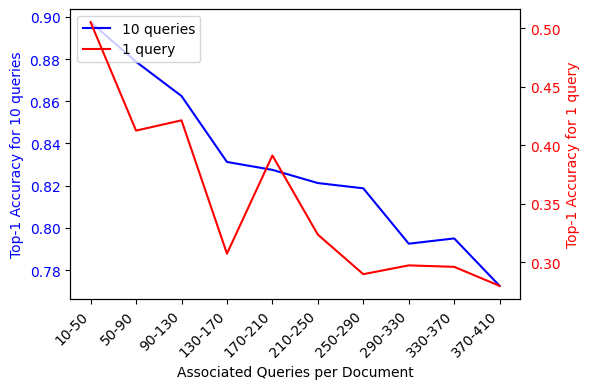

<Figure size 640x480 with 0 Axes>

In [85]:
def get_data(n_docs, n_queries, k=1):
    runs = wandb.Api().runs(f"tribler/doc-pop-{n_docs}-{n_queries}")
    intermediate_values = {}
    for run in runs:
        # Attempt to get 'top1_acc' value; if not available, default to None
        intermediate_values[int(run.name)] = run.summary.get(f'top{k}_acc', None)
    
    # Sort the items and prepare for aggregation
    sorted_items = sorted(intermediate_values.items())
    
    # Aggregating four consecutive values
    aggregated_keys = []
    aggregated_values = []
    temp_values = []  # Temporary storage for up to four values
    for i, (key, value) in enumerate(sorted_items):
        temp_values.append(value)
        # Every four values, or at the end of the list, perform the aggregation
        if (i + 1) % 4 == 0 or i + 1 == len(sorted_items):
            # Ensure we are not dividing by zero
            if temp_values:
                # Calculate the average of the values
                avg_value = sum(filter(None, temp_values)) / len(temp_values)
                aggregated_keys.append(f'{sorted_items[i-3][0]*10}-{key*10+10}')
                aggregated_values.append(avg_value)
                temp_values = []  # Reset for the next group
    
    return aggregated_keys, aggregated_values


fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the first dataset using the left y-axis
labels, values = get_data(100, 10)
line1, = ax1.plot(labels, values, label='10 queries', color='b')
ax1.set_xlabel('Associated Queries per Document')
ax1.set_ylabel('Top-1 Accuracy for 10 queries', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(labels, rotation=45, ha="right")

# Create a second y-axis for the second dataset
ax2 = ax1.twinx()
labels, values = get_data(100, 1)
line2, = ax2.plot(labels, values, label='1 query', color='r')
ax2.set_ylabel('Top-1 Accuracy for 1 query', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a legend for both lines
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()  # Make sure the layout is nicely arranged
plt.show()

tikzplotlib.save("../plots/doc_pop_accs.tex", axis_width=r'\columnwidth', axis_height=r'4cm')